In [1]:
%load_ext autoreload
%autoreload 2

from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df, create_continuity_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

continuity = create_continuity_df('data/raw/continuity.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]
small_test = (test_caregivers, test_tasks)

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]
car_test = (car_caregivers, car_tasks)

full_test = (caregivers, tasks)

print(len(car_caregivers))
print(len(car_tasks))
# Get the number of unique clients in the car_tasks dataset
car_clients = car_tasks['ClientID'].nunique()
print(f"Number of unique clients: {car_clients}")


17
160
Number of unique clients: 60


In [ ]:
from models.fixed_model import FixedModel
from models.tsp_model import TSPModel
from models.hexaly_model import HexalyModel
from models.tsp_model_strict import TSPModelStrict
model_type = HexalyModel
model_caregivers, model_tasks = small_test

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix, continuity)
model.build(
        # caregiver_penalty=0,
        # overtime_penalty=0,
        worktime_per_break=0,
        continuity_penalty=0,
        # warm_start=True
)

Building fixed model.
Set parameter Username
Set parameter LicenseID to value 2635249
Academic license - for non-commercial use only - expires 2026-03-11
Created base variables.
Built base model.
Adding overtime penalties.
Adding caregiver usage penalties.
Updated objective function with penalties.


<gurobi.Model Continuous instance HomeCare: 0 constrs, 0 vars, Parameter changes: Username=(user-defined), LicenseID=2635249>

In [14]:
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2932 rows, 437971 columns and 1766468 nonzeros
Model fingerprint: 0x84d1133d
Variable types: 34 continuous, 437937 integer (437937 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [8e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 127 rows and 38566 columns
Presolve time: 1.66s
Presolved: 2805 rows, 399405 columns, 1589770 nonzeros
Variable types: 0 continuous, 399405 integer (399371 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.374e+05
 Factor NZ  : 2.914e+05 (roughly 40 MB of memory)
 Factor Ops : 1.472e+08 (less than 1 second per iteration)
 Th

<gurobi.Model MIP instance HomeCare: 2932 constrs, 437971 vars, Parameter changes: Username=(user-defined), LicenseID=2635249>

<string>:273: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


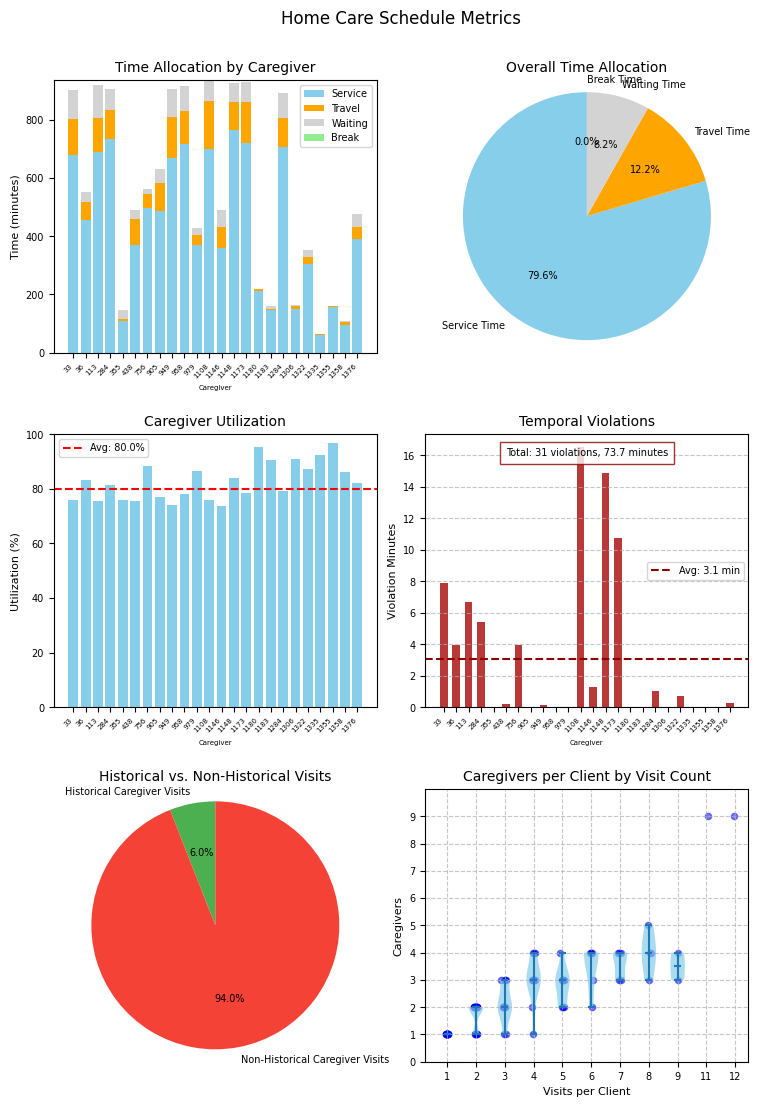

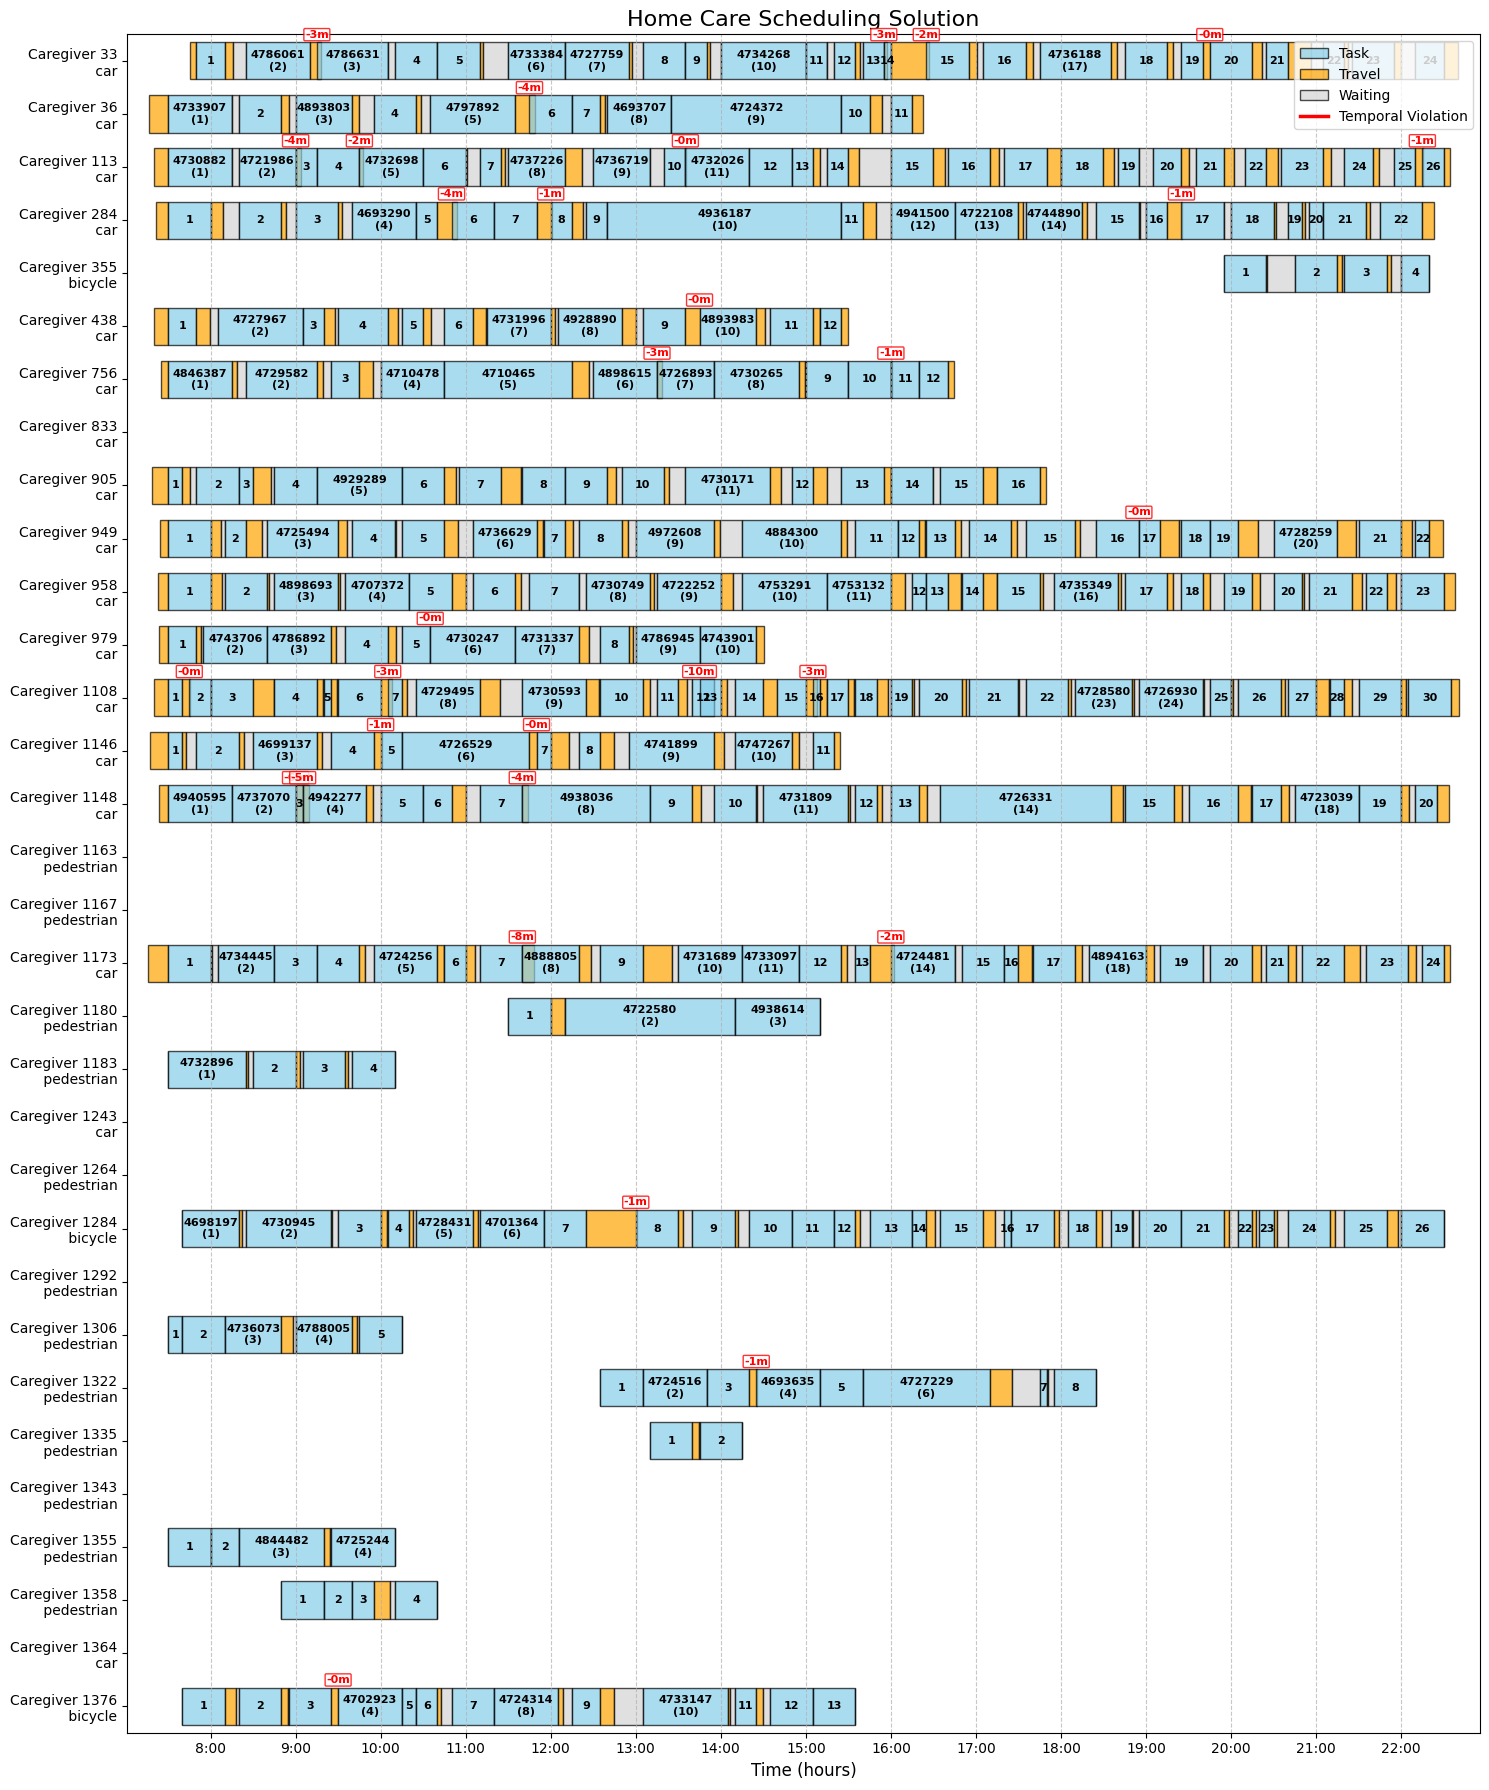

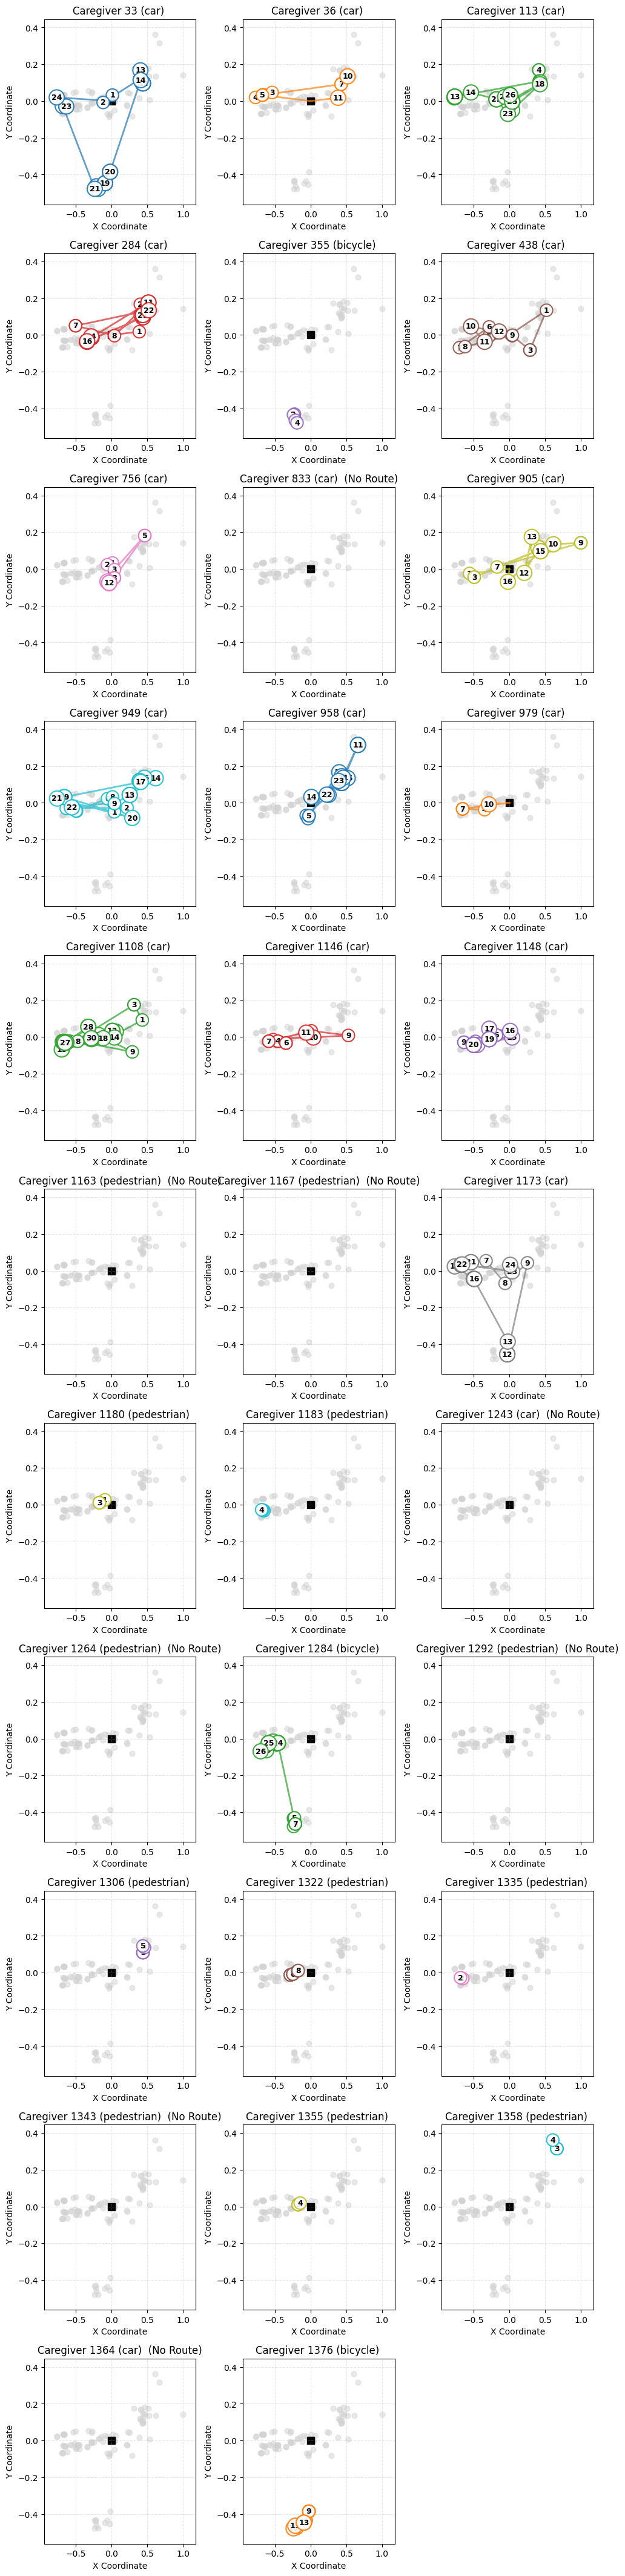

In [28]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes, display_metrics_summary

model.get_solution()

metrics_plot = visualize_metrics(model, display_mode='dashboard');
schedule_plot = visualize_schedule(model);
route_plot = visualize_routes(model, caregiver_ids=None, subplot_mode=True);
#display_metrics_summary(model)



In [ ]:
import matplotlib.pyplot as plt
plt.savefig("figures/base_metrics.pdf", format="pdf", bbox_inches="tight")
plt.savefig("figures/base_schedule.pdf", format="pdf", bbox_inches="tight")
plt.savefig("figures/base_route.pdf", format="pdf", bbox_inches="tight")



In [6]:
from utils.solution_storage import save_solution
save_solution(model, 'overtime_penalty_1-lateness_5-caregiver_60')

Solution saved to data/saved_solutions/20250413_002553_overtime_penalty_1-lateness_5-caregiver_60.json


'data/saved_solutions/20250413_002553_overtime_penalty_1-lateness_5-caregiver_60.json'

  Total time: 917.55, Accounted time: 923.10
  Service: 640.00, Travel: 130.27, Waiting: 152.83, Break: 0.00
  Total time: 406.97, Accounted time: 408.60
  Service: 340.00, Travel: 50.32, Waiting: 18.28, Break: 0.00
  Total time: 917.55, Accounted time: 923.10
  Service: 640.00, Travel: 130.27, Waiting: 152.83, Break: 0.00
  Total time: 406.97, Accounted time: 408.60
  Service: 340.00, Travel: 50.32, Waiting: 18.28, Break: 0.00


/Users/vilhelmkarlin/Code/KTH/SA120X_KEX/utils/visualization.py:812: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dashboard_fig.show()


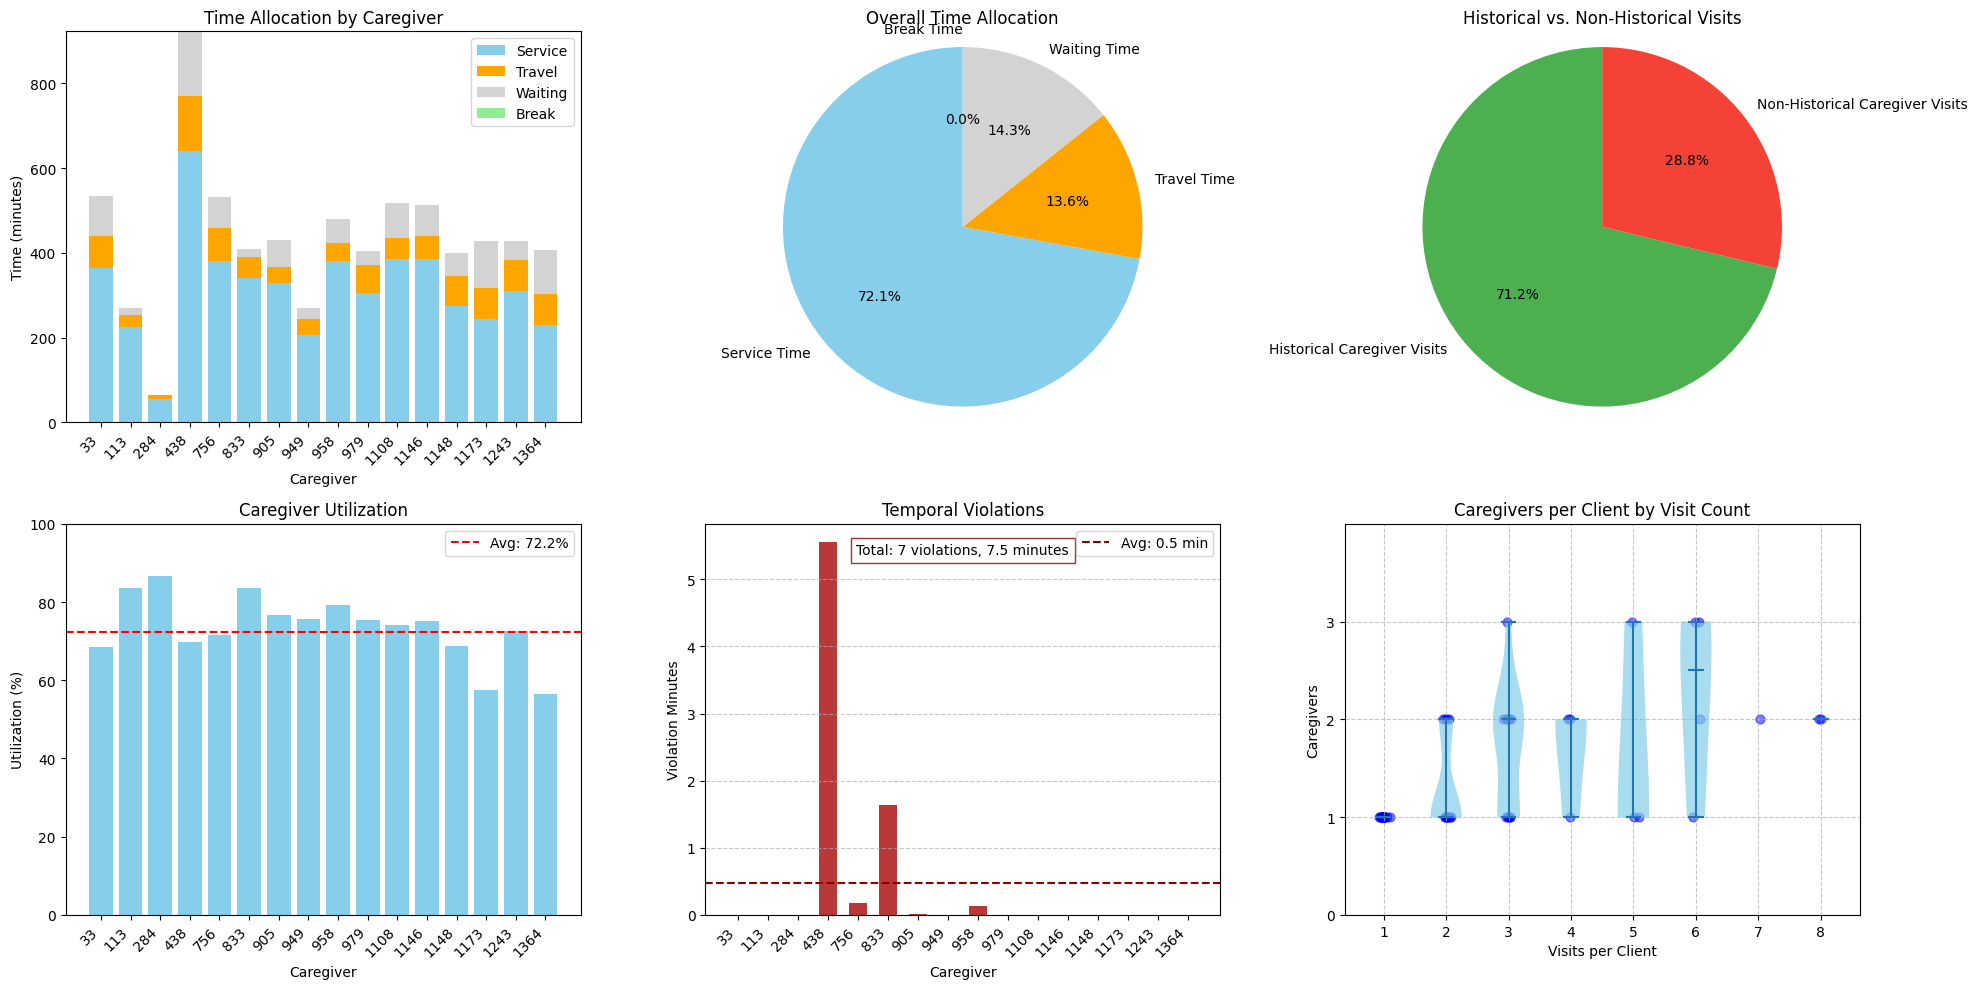

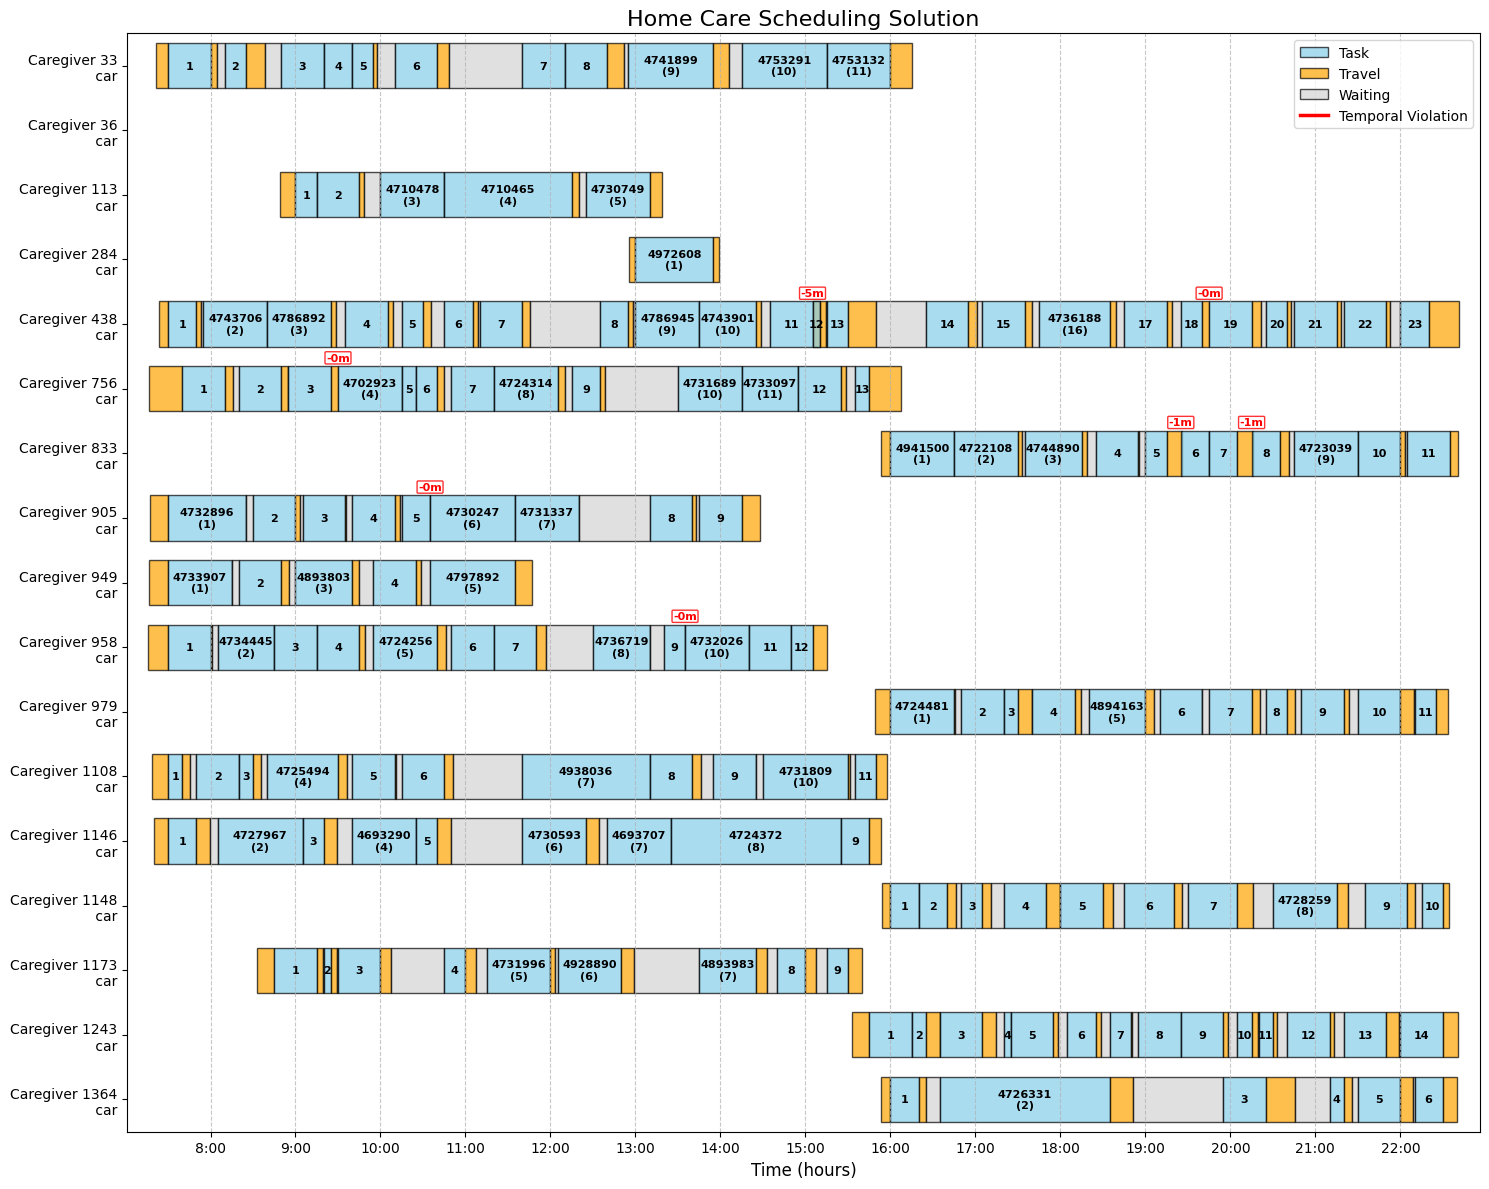

In [20]:
from utils.solution_storage import create_model_from_real_data

real_data_model = create_model_from_real_data(model.caregivers, model.tasks, model.clients, model.drive_time_matrix, model.walk_time_matrix, model.bicycle_time_matrix, model.continuity)

# display_metrics_summary(real_data_model)
visualize_metrics(real_data_model, display_mode='dashboard');
visualize_schedule(real_data_model);
# visualize_routes(real_data_model, caregiver_ids=None, subplot_mode=True)
